# Inverse Ising Problem
The inverse problem is to learn the values of the weight matrix using the statistics of the system. This code infers the interaction parameters of the classical hamiltonian from the statistics using a classical Boltzmann machine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float_kind':"{:.6f}".format}) # print matrices in 2 decimals

The functions below are copy-paste from the forward ising code

In [38]:
# WEIGHT FUNCTIONS
#-----------------------------------------------------------------------------------------------------------
def generate_weights_nearest_neighbour(L, w, h):
    '''Generates weights array with only nearest neighbour interactions and periodic boundary conditions''' 
    N = L**2
    W = np.zeros((N, N))
    for i in range(L):
        for j in range(L):
            site  = L * i             + j
            east  = L * i             + (j + 1) % L
            west  = L * i             + (j - 1) % L
            north = L * ((i + 1) % L) + j
            south = L * ((i - 1) % L) + j
            
            W[site, east]  += w
            W[site, west]  += w
            W[site, north] += w
            W[site, south] += w
            W[site, site]  += h
    return W

def generate_weights_fully_connected(L, w, h):
    '''Generates weights array for a fully connected system'''
    N = L**2
    W = (np.ones((N, N)) * w) / N 
    np.fill_diagonal(W, 0)
    H = (np.ones((N)) * h) / L
    return W, H

def generate_weights_random(L, w, h, sigma, seed):
    '''Generates a symmetric random weights array drawn from a normal distribution for a given seed'''
    N = L**2      
    rng = np.random.default_rng(seed)                    #  set random seed for reproduciblity
    W_assym = rng.normal(w/N, sigma/(N**(1/2)),(N, N))   #  get normal distributed weight matrix that scales with w
    W = (W_assym+ W_assym.T)/2                           #  symmetrize the random matrix 
    np.fill_diagonal(W, np.diag(W) * (h/w))              #  scale diagonal with h values     
    return W 

In [3]:
###  SIMULATION HELPER FUNCTIONS
#----------------------------------------------------------------------
def initial_config(L):   
    '''Generates a 1D array of length N with random binary spin values'''
    return np.random.choice([-1, 1], size=(L**2))

def all_possible_configs(L):
    '''Generates all possible configurations of a binary spin system of size N'''
    N = L**2
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

def calcEnergy(config, W):
    '''Calculates the energy of a given configuration'''
    energy = -np.dot(config.T,np.dot(W, config)) / 2 - np.dot(np.diagonal(W),config)
    return energy

def calcCorr(config): 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)


def heat_bath_move(config, W, beta):
    '''Implements a Monte Carlo sweep using the heat bath algorithm'''
    N = config.shape[0]
    for i in range(N):                                 #  this for loop ensures we perform a sweep
        a  = np.random.randint(N)                      #  choose a random spin i 
        lf = config[a] * np.dot(W[a],config)             #  calculate local field energy of spin i
        p  = np.exp(-2 * beta * lf)                    #  probability of flipping spin i
        if np.random.rand() < p:
            config[a] = -config[a]
    return config

Since the free statistics have to be calculated at each iteration of the gradient ascent loop, we want our functions to calculate the free statistics as efficient as possible. We first start by simplifying the solver functions defined for the forward Ising problem. We can recycle a lot of the code that we used for the forward Ising problem.

In [4]:
###  GET SIMPLIFIED SOLVER FUNCTIONS
#----------------------------------------------------------------------
def ising_solve_exact_simplified(L, W,H, T, configs):    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    N = L**2
    beta = 1.0/T 
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,W,H)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this 
                                                      #  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj

def ising_solve_mc_simplified(L, W, T, config, mcSteps):    
    '''Calculate the free statistics for a single temperature using Monte Carlo Heat Bath sampling'''
    N = L**2
    beta = 1.0/T  
    C1, C2 = np.zeros((N)),np.zeros((N,N))       #  initialize arrays to store variables 

    for i in range(mcSteps):   
        config = heat_bath_move(config, W, beta) #  performs a sweep. no need to equilibrate.  
        Ene    = calcEnergy(config,W)
        Corr   = calcCorr(config)      
 
        C1 += config
        C2 += Corr
   
    Ci    = C1 / mcSteps
    CiCj  = C2 / mcSteps
        
    return Ci,CiCj,config

I've checked and the exact function recover the exact same values for Ci and CiCj as the more expansive version does. Given enough mcSteps, the simplified mc function also converges to the same values as the non-simplified mc function.

In [5]:
## SOLVE USING EXACT COMPUTATION 
#----------------------------------------------------------------------
def solve_inverse_ising(L, T, w, h, eqSteps, mcSteps, W_type, Clamp_type, Free_type, threshold, maxiter, eta):
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
       and the inferred weight matrix'''
    N    = L**2
    beta = 1.0 / T 
    
    #  initialize weight matrix
    if W_type == 0:                                           
        W_clamp = generate_weights_random(L, w, h, sigma, seed_clamp)         
    elif W_type == 1:                                         
        W_clamp = generate_weights_nearest_neighbour(L,w,h)
    elif W_type == 2:
        W_clamp, H_clamp = generate_weights_fully_connected(L,w,h) 
    else:
        print("Non-valid weight matrix type")
        
    #  generate the clamped statistics based on solver type
    if Clamp_type == 0:
        configs = all_possible_configs(L)
        Ci_clamp, CiCj_clamp = ising_solve_exact_simplified(L, W_clamp, T, configs)

    if Clamp_type == 1:
        config = initial_config(L)                             #  intialize a state
        for i in range(eqSteps):                               #  equilibrate
            config    = heat_bath_move(config, W_clamp, beta)
        Ci_clamp, CiCj_clamp, config = ising_solve_mc_simplified(L, W_clamp, T, config, mcSteps)   
        
    config = initial_config(L)                             #  initialize new state for free statistics 

    #  get random initial weights that generate free statistics 
    W = generate_weights_random(L, w, h, sigma, seed_free)     #  use different seed than for clamped stats
    H = W.diagonal()                                           #  get self-interactions
    
    #  initialize gradient ascent values  
    it    = 0
    H_max = W_max = 1    
    Hmax_values, Wmax_values = [], []  #store values to plot
    
    while it < maxiter:        #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        if Free_type == 0:
            Ci_free, CiCj_free = ising_solve_exact_simplified(L, W, T, configs) 

        elif Free_type == 1:
            Ci_free, CiCj_free, config = ising_solve_mc_simplified(L, W, T, config, mcSteps)
            
        H     = H + eta * (Ci_clamp   - Ci_free)               #  update weight matrix based on statistics  
        W     = W + eta * (CiCj_clamp - CiCj_free)
        np.fill_diagonal(W, H)                                 #  update diagonal weights to W

        H_max = np.abs(np.max(Ci_free - Ci_clamp))
        W_max = np.abs(np.max(CiCj_free - CiCj_clamp))
        
        Hmax_values.append(H_max)
        Wmax_values.append(W_max)
        
    return W, W_clamp, it, Hmax_values, Wmax_values

In [6]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, legend = False, labels = []):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=10, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot_convergences(it,Hmax,Wmax):
    fig = plt.figure(figsize=(20, 20));                           #  make plots
    fig.suptitle('Convergence Plots', fontsize=30, y = 0.91)

    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(2, 2, 1)
    plot_scatter(ax1, its, Hmax, "Iterations", "H", "HotPink")

    ax2 = fig.add_subplot(2, 2, 2)
    plot_scatter(ax2, its, Wmax, "Iterations", "W", "Coral")
    
def plot_likelihood(it,L):
    fig = plt.figure(figsize=(20, 20));                           #  make plots
    fig.suptitle('Likelihood Convergence', fontsize=30, y = 0.91)

    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(2, 2, 1)
    plot_scatter(ax1, its, dL, "Iterations", "Likelihood", "ForestGreen")

In [29]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
L           = 2        #  linear dimension of the LxL lattice
T           = 1        #  temperature scalar
w           = 1        #  strength of interactions 
h           = 1        #  strength of self-interactions
W_type      = 2        #  0 for random weights, 1 for nb, 2 for fully connected
Clamp_type  = 0        #  determine how the clamped statistics are generated (0 exact, 1 mc)
Free_type   = 0        #  determine how the free statistics are generated (0 exact, 1 mc)
eqSteps     = 2**10    #  number of MC sweeps for equilibration
mcSteps     = 2**14    #  number of MC sweeps for calculation

# gradient ascent parameters 
threshold   = 1e-13     #  threshold for stopping the gradient ascent loop
maxiter     = 2**10     #  maximum number of gradient ascent iterations
eta         = 1/20      #  learning rate

#random weights parametes
seed_clamp  = 777       
seed_free   = 333
sigma       = .1

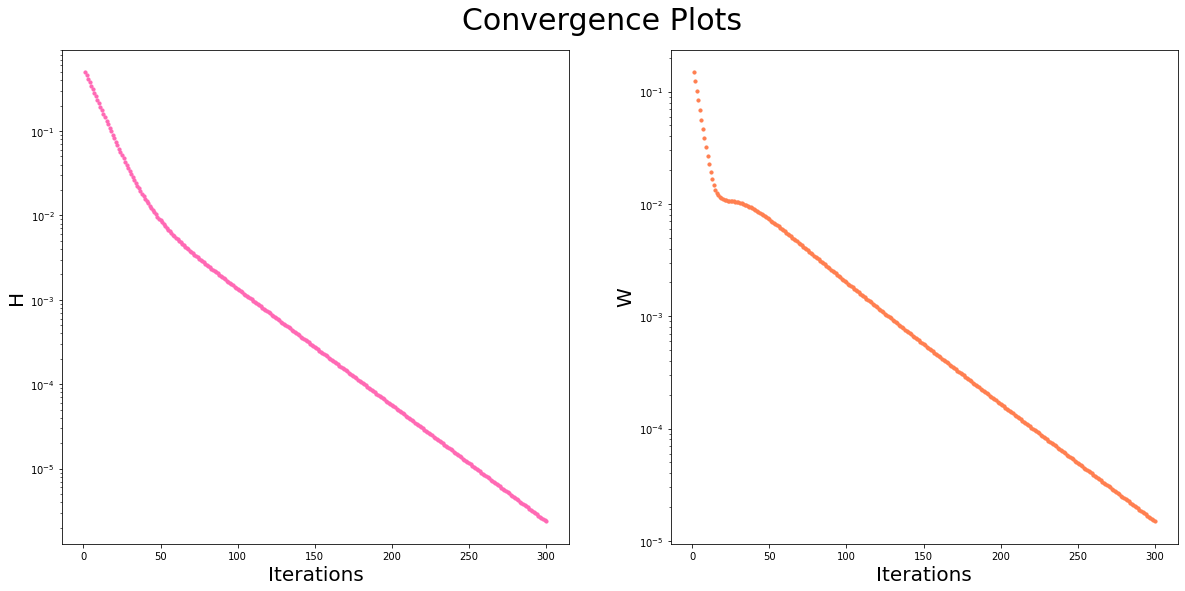

In [31]:
W, W_clamp, it, Hmax, Wmax= solve_inverse_ising(L, T, w, h, eqSteps, mcSteps, 
                                                  W_type, 0, 0, 1e-6, 300, 1/20)
plot_convergences(it,Hmax,Wmax)
plt.savefig('Figures/Inverse Ising Problem/help', bbox_inches='tight')

In [32]:
print(np.abs(W - W_clamp))

[[0.000003 0.000031 0.000002 0.000029]
 [0.000031 0.000002 0.000030 0.000001]
 [0.000002 0.000030 0.000003 0.000031]
 [0.000029 0.000001 0.000031 0.000004]]


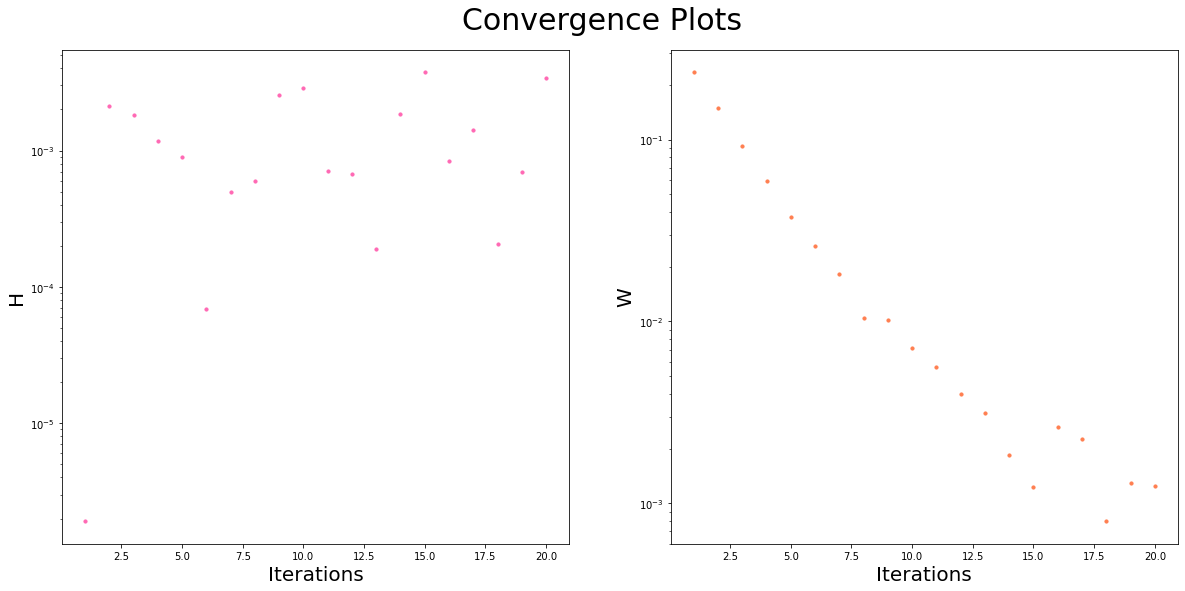

In [23]:
W, W_clamp, it, Hmax, Wmax= solve_inverse_ising(L, T, w, h, eqSteps, 2**20, 
                                                  W_type, 0, 1, 1e-6, 20, 1/4)
plot_convergences(it,Hmax,Wmax)
plt.savefig('Figures/Inverse Ising Problem/MEGA MCMC POG', bbox_inches='tight')

In [26]:
print(np.abs(W - W_clamp))

[[0.202036 0.088087 0.079467 0.092769]
 [0.088087 0.263998 0.086941 0.100515]
 [0.079467 0.086941 0.189976 0.089339]
 [0.092769 0.100515 0.089339 0.289018]]


In [28]:
print(W_clamp)

[[0.000000 0.250000 0.250000 0.250000]
 [0.250000 0.000000 0.250000 0.250000]
 [0.250000 0.250000 0.000000 0.250000]
 [0.250000 0.250000 0.250000 0.000000]]


# ----------------------------------DANGER ZONE----------------------------------

The statistics generated by the MC simulation does not converge to the exact calculation, even for extremely high temperatures and large amounts of samples:

In [41]:
L = 2
w = 1
h = 1
W, H = generate_weights_fully_connected(L, w, h)

T = 1                #extreme temperature above the critical temperature; MCMC should be able to sample it properly
beta = 1.0/T        
eqSteps = 2**12
mcSteps = 2**20      #large amount of mcSteps; does not converge

In [43]:
print(W)

[[0.000000 0.250000 0.250000 0.250000]
 [0.250000 0.000000 0.250000 0.250000]
 [0.250000 0.250000 0.000000 0.250000]
 [0.250000 0.250000 0.250000 0.000000]]


In [19]:
#exact statistics
configs = all_possible_configs(L)
Ci_ex, CiCj_ex = ising_solve_exact_simplified(L, W, T, configs)

#mcmc statistics
config = initial_config(L)                             #  intialize a state
for i in range(eqSteps):                               #  equilibrate
    config    = heat_bath_move(config, W, beta)
Ci_mc, CiCj_mc, config = ising_solve_mc_simplified(L, W, T,config, mcSteps)

In [21]:
print(np.abs((Ci_ex - Ci_mc)))

print(np.abs(CiCj_ex - CiCj_mc))

[0.001272 0.000244 0.001064 0.000593]
[[0.000000 0.000506 0.001391 0.000508]
 [0.000506 0.000000 0.000847 0.000998]
 [0.001391 0.000847 0.000000 0.000776]
 [0.000508 0.000998 0.000776 0.000000]]


In [20]:
print(Ci_ex)
print(CiCj_ex)

[0.000000 0.000000 0.000000 0.000000]
[[1.000000 0.376182 0.376182 0.376182]
 [0.376182 1.000000 0.376182 0.376182]
 [0.376182 0.376182 1.000000 0.376182]
 [0.376182 0.376182 0.376182 1.000000]]


In [22]:
print(Ci_mc)
print(CiCj_mc)

[0.001272 -0.000244 -0.001064 -0.000593]
[[1.000000 0.376688 0.377573 0.376690]
 [0.376688 1.000000 0.377029 0.377180]
 [0.377573 0.377029 1.000000 0.375406]
 [0.376690 0.377180 0.375406 1.000000]]
